## read raw data

In [1]:
from loguru import logger
from transformers import AutoTokenizer
from torchtext.data import get_tokenizer
import os

class Options:
    def __init__(self, name) -> None:
        self.name= name
    def name(self):
        return self.name

# project gloal parameter
options = Options("Model")
options.base_path="/home/yang/github/fuzzys2s/"
options.SOS = 0 # start of sentence
options.EOS = 1 # End of sentence
options.PAD = 2 # padding token
options.UNK = 3 # unknown token, word frequency low
options.count_max = 2000
options.size_max = 50
options.seq_max = 2000

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<sos>":options.SOS, "<eos>":options.EOS, "<pad>":options.PAD,"<unk>":options.UNK}
        self.word2count = {"<sos>":1, "<eos>":1, "<pad>":1,"<unk>":1}
        self.index2word = {options.SOS: "<sos>", options.EOS: "<eos>", options.PAD:"<pad>",options.UNK: "<unk>"}
        self.n_words = 4  # Count PAD , SOS and EOS
        self.feature_max = [] # max value of feature
        self.feature_min = [] # min value of feature
        self.line_max = 0 # max length of sentence

    def addTokens(self, tokens):
        for word in tokens:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def build_vocab(vocab_src, vocab_tgt, tokens):
    for sentence in tokens:
        src = sentence[0]
        tgt = sentence[1]
        vocab_src.addTokens(src)
        vocab_tgt.addTokens(tgt)
        if len(src) > vocab_src.line_max:
            vocab_src.line_max = len(src)
        if len(tgt) > vocab_tgt.line_max:
            vocab_tgt.line_max = len(tgt)
    return vocab_src, vocab_tgt

def get_base_tokenizer(name):
    tokenizer_path = options.base_path+"output/"+name+"/"
    if os.path.exists(tokenizer_path):
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    else:
        tokenizer = AutoTokenizer.from_pretrained(name)
        tokenizer.save_pretrained(tokenizer_path)
    return tokenizer.tokenize

def gen_token_vectors(vocab_src, vocab_tgt, tokens):
    token_vectors =[]
    for row in tokens:
        src = [vocab_src.word2index[word]  for word in row[0]]
        tgt = [vocab_tgt.word2index[word]  for word in row[1]]
        token_vectors.append([src, tgt])
    return token_vectors

def read_line_pair(src_path, tgt_path):
    src_fd = open(src_path, "r")
    tgt_fd = open(tgt_path, "r")
    src_lines = src_fd.readlines()
    tgt_lines = tgt_fd.readlines()
    lines =[]
    for i  in range(len(src_lines)):
        src = src_lines[i]
        tgt = tgt_lines[i]
        lines.append([src, tgt])
    src_fd.close()
    tgt_fd.close()
    return lines

def read_magic_data(tokenizer):
    logger.info("read raw data")
    train_lines = read_line_pair(options.base_path+'doc/magic/train_magic.in', options.base_path+'doc/magic/train_magic.out')
    valid_lines = read_line_pair(options.base_path+'doc/magic/dev_magic.in', options.base_path+'doc/magic/dev_magic.out')
    test_lines = read_line_pair(options.base_path+'doc/magic/test_magic.in', options.base_path+'doc/magic/test_magic.out')
    train_tokens=[]
    valid_tokens=[]
    test_tokens=[]
    for src, tgt in train_lines:
        src_tokens = tokenizer(src)
        tgt_tokens = tokenizer(tgt)
        train_tokens.append([src_tokens, tgt_tokens])
    for src, tgt in valid_lines:
        src_tokens = tokenizer(src)
        tgt_tokens = tokenizer(tgt)
        valid_tokens.append([src_tokens, tgt_tokens])
    for src, tgt in test_lines:
        src_tokens = tokenizer(src)
        tgt_tokens = tokenizer(tgt)
        test_tokens.append([src_tokens, tgt_tokens])
    logger.info("build vocabulary")
    vocab_src = Vocab("src")
    vocab_tgt = Vocab("tgt")
    build_vocab(vocab_src, vocab_tgt, train_tokens)
    build_vocab(vocab_src, vocab_tgt, valid_tokens)
    build_vocab(vocab_src, vocab_tgt, test_tokens)
    logger.info("src vocab name:%s, size:%d" %(vocab_src.name, vocab_src.n_words))
    logger.info("tgt vocab name:%s, size:%d" %(vocab_tgt.name, vocab_tgt.n_words))
    logger.info("generate token vectors")
    train_data = gen_token_vectors(vocab_src, vocab_tgt, train_tokens)
    valid_data = gen_token_vectors(vocab_src, vocab_tgt, valid_tokens)
    test_data = gen_token_vectors(vocab_src, vocab_tgt, test_tokens)
    return train_data, valid_data, test_data, vocab_src, vocab_tgt

## plot graph1

2023-05-09 12:13:56.063 | INFO     | __main__:read_magic_data:88 - read raw data
2023-05-09 12:13:56.949 | INFO     | __main__:read_magic_data:107 - build vocabulary
2023-05-09 12:13:58.368 | INFO     | __main__:read_magic_data:113 - src vocab name:src, size:13714
2023-05-09 12:13:58.371 | INFO     | __main__:read_magic_data:114 - tgt vocab name:tgt, size:36648
2023-05-09 12:13:58.373 | INFO     | __main__:read_magic_data:115 - generate token vectors
2023-05-09 12:13:59.238 | INFO     | __main__:read_magic_data:88 - read raw data
Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors
2023-05-09 12:14:07.211 | INFO     | __main__:read_magic_data:107 - build vocabulary
2023-05-09 12:14:09.923 | INFO     | __main__:read_magic_data:113 - src vocab name:src, size:7764
2023-05-09 12:14:09.929 | INFO     | __main__:read_magic_data:114 - tgt vocab name:tgt, size:9217
2

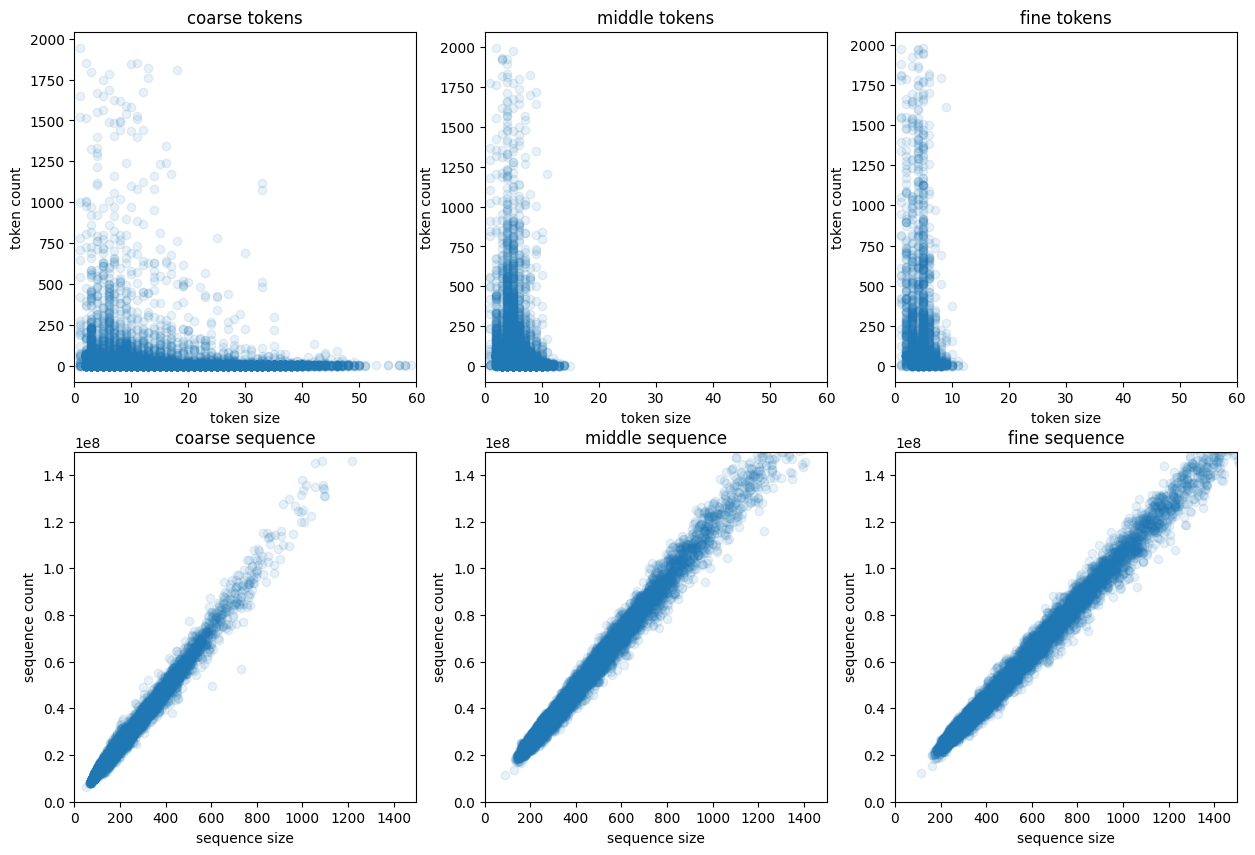

In [90]:
from matplotlib import pyplot as plt
import numpy as np
logger.add(options.base_path+'output/magic-analyze.log')
count_limit = 100
def get_seq_count(seq, vocab):
    seq_count = 0
    for idx in seq:
        token = vocab.index2word[idx]
        seq_count = seq_count + vocab.word2count[token]
    return seq_count

def read_data(tokenizer):
    train_data, valid_data, test_data, vocab_src, vocab_tgt=read_magic_data(tokenizer)
    src_data = []
    for i in range(vocab_src.n_words):
        word = vocab_src.index2word[i]
        count = vocab_src.word2count[word]
        if count > count_limit:
            continue
        src_data.append([len(word), count])
    src_data = np.array(src_data)
    tgt_data = []
    for i in range(vocab_tgt.n_words):
        word = vocab_tgt.index2word[i]
        count = vocab_tgt.word2count[word]
        if count > count_limit:
            continue
        tgt_data.append([len(word), count])
    tgt_data = np.array(tgt_data)
    
    src_seq = np.empty((len(train_data), 2))
    tgt_seq = np.empty((len(train_data), 2))
    for i in range(len(train_data)):
        src = train_data[i][0]
        tgt = train_data[i][1]
        src_len = len(src)
        tgt_len = len(tgt)
        src_count = get_seq_count(src, vocab_src)
        tgt_count = get_seq_count(tgt, vocab_tgt)
        src_seq[i][0] = src_len
        src_seq[i][1] = src_count
        tgt_seq[i][0] = tgt_len
        tgt_seq[i][1] = tgt_count
    return src_data, tgt_data, src_seq, tgt_seq

tokenizer = get_tokenizer("basic_english")
coarse_src_data, coarse_tgt_data, coarse_src_seq, coarse_tgt_seq = read_data(tokenizer)
tokenizer = get_base_tokenizer('bert-base-uncased')
middle_src_data,middle_tgt_data, middle_src_seq,middle_tgt_seq = read_data(tokenizer)
tokenizer = get_base_tokenizer('vs4000_wmt14_tokenizer')
fine_src_data,fine_tgt_data, fine_src_seq,fine_tgt_seq = read_data(tokenizer)


f, axes = plt.subplots(2, 3, figsize=(15,10))

sub_graph = axes[0][0]
data = coarse_tgt_data
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("coarse tokens")
sub_graph.set_xlabel("token size")
sub_graph.set_ylabel("token count")
sub_graph.set_xlim((0,60))

sub_graph = axes[0][1]
data = middle_tgt_data
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("middle tokens")
sub_graph.set_xlabel("token size")
sub_graph.set_ylabel("token count")
sub_graph.set_xlim((0,60))

sub_graph = axes[0][2]
data = fine_tgt_data
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("fine tokens")
sub_graph.set_xlabel("token size")
sub_graph.set_ylabel("token count")
sub_graph.set_xlim((0,60))

sub_graph = axes[1][0]
data = coarse_tgt_seq
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("coarse sequence")
sub_graph.set_xlabel("sequence size")
sub_graph.set_ylabel("sequence count")
sub_graph.set_xlim((0,1500))
sub_graph.set_ylim((0,150000000))

sub_graph = axes[1][1]
data = middle_tgt_seq
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("middle sequence")
sub_graph.set_xlabel("sequence size")
sub_graph.set_ylabel("sequence count")
sub_graph.set_xlim((0,1500))
sub_graph.set_ylim((0,150000000))

sub_graph = axes[1][2]
data = fine_tgt_seq
sub_graph.scatter(data[:,0], data[:,1], alpha=.1)
sub_graph.set_title("fine sequence")
sub_graph.set_xlabel("sequence size")
sub_graph.set_ylabel("sequence count")
sub_graph.set_xlim((0,1500))
sub_graph.set_ylim((0,150000000))

plt.show()

## plot graph2

2023-05-11 13:36:50.503 | INFO     | __main__:read_magic_data:91 - read raw data
2023-05-11 13:36:51.509 | INFO     | __main__:read_magic_data:110 - build vocabulary
2023-05-11 13:36:53.458 | INFO     | __main__:read_magic_data:116 - src vocab name:src, size:13714
2023-05-11 13:36:53.459 | INFO     | __main__:read_magic_data:117 - tgt vocab name:tgt, size:36648
2023-05-11 13:36:53.460 | INFO     | __main__:read_magic_data:118 - generate token vectors


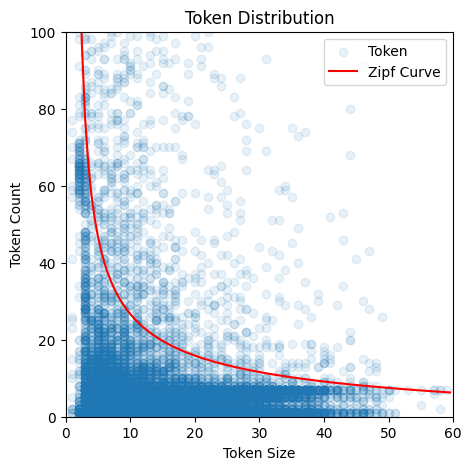

In [39]:

from matplotlib import pyplot as plt
import numpy as np
import math
logfile = logger.add(options.base_path+'output/magic-analyze.log')
count_limit = 100
def get_seq_count(seq, vocab):
    seq_count = 0
    for idx in seq:
        token = vocab.index2word[idx]
        seq_count = seq_count + vocab.word2count[token]
    return seq_count

def read_data(tokenizer):
    train_data, valid_data, test_data, vocab_src, vocab_tgt=read_magic_data(tokenizer)
    src_data = []
    for i in range(vocab_src.n_words):
        word = vocab_src.index2word[i]
        count = vocab_src.word2count[word]
        if count > count_limit:
            continue
        src_data.append([len(word), count])
    src_data = np.array(src_data)
    tgt_data = []
    for i in range(vocab_tgt.n_words):
        word = vocab_tgt.index2word[i]
        count = vocab_tgt.word2count[word]
        if count > count_limit:
            continue
        tgt_data.append([len(word), count])
    tgt_data = np.array(tgt_data)
    
    src_seq = np.empty((len(train_data), 2))
    tgt_seq = np.empty((len(train_data), 2))
    for i in range(len(train_data)):
        src = train_data[i][0]
        tgt = train_data[i][1]
        src_len = len(src)
        tgt_len = len(tgt)
        src_count = get_seq_count(src, vocab_src)
        tgt_count = get_seq_count(tgt, vocab_tgt)
        src_seq[i][0] = src_len
        src_seq[i][1] = src_count
        tgt_seq[i][0] = tgt_len
        tgt_seq[i][1] = tgt_count
    return src_data, tgt_data, src_seq, tgt_seq

tokenizer = get_tokenizer("basic_english")
coarse_src_data, coarse_tgt_data, coarse_src_seq, coarse_tgt_seq = read_data(tokenizer)
zipf_data = []
zipf_x = np.arange(1,60, 0.5)
for i in range(len(zipf_x)):
    x = zipf_x[i]
    if x > 1:
        val = 60 * 1/math.log(x, 6) -20
        zipf_data.append([x,val])
zipf_data = np.array(zipf_data)
f, axes = plt.subplots(1, 1, figsize=(5,5))

sub_graph = axes
data = coarse_tgt_data
sub_graph.scatter(data[:,0], data[:,1], alpha=.1, label='Token')
sub_graph.plot(zipf_data[:,0], zipf_data[:,1], color='red', label='Zipf Curve')
sub_graph.set_title("Token Distribution")
sub_graph.set_xlabel("Token Size")
sub_graph.set_ylabel("Token Count")
sub_graph.set_xlim((0,60))
sub_graph.set_ylim((0,100))
sub_graph.legend()
plt.show()

logger.remove(logfile)